In [1]:
# Import packages and set configuration
from IPython.display import display

%load_ext autoreload
%autoreload 2

In [2]:
# Load tickers
tickers = ["BTCUSDT", "ETHUSDT", "BNBUSDT", "SOLUSDT", "XRPUSDT", "ADAUSDT", "AVAXUSDT", "DOGEUSDT", "TRXUSDT",
           "DOTUSDT", "LINKUSDT", "SHIBUSDT", "LTCUSDT", "BCHUSDT", "UNIUSDT"]

In [3]:
ps_start = "2024-02-01"
ps_end = "2024-03-01"

trading_start = "2024-03-01"
trading_end = "2024-04-01"

interval = "1h"

In [4]:
# Load data
from modules.data_services.data_pipeline import load_data

df = load_data(
    tickers=tickers,
    start=ps_start,
    end=ps_end,
    interval=interval
)

In [5]:
# Pair Selection
from modules.pair_selection.statistical_tests import johansen_cointegration

joh_df = johansen_cointegration(df)
display(joh_df.head(5))
tickers = joh_df.iloc[0:1, 0].tolist()

,pair,trace_stat,crit_95,crit_99,trace_stat - crit_95,trace_stat - crit_99
0,DOGEUSDT-SHIBUSDT,30.972490,15.4943,19.9349,15.478190,11.037590
1,ETHUSDT-LINKUSDT,23.242135,15.4943,19.9349,7.747835,3.307235
2,AVAXUSDT-LINKUSDT,21.904639,15.4943,19.9349,6.410339,1.969739
3,BTCUSDT-DOTUSDT,21.865188,15.4943,19.9349,6.370888,1.930288
4,XRPUSDT-DOTUSDT,21.634823,15.4943,19.9349,6.140523,1.699923


In [6]:
fee_rate = 0.0005  # 0.05%
initial_cash = 100000
position_size = 1  # always 100% of portfolio

entry_threshold = 2 # 2 std from z-score
exit_threshold = 0
stop_loss = 1.5 #1.5 of an entry threshold; 150%
rolling_window = 100

In [7]:
# Load pair and calculate returns
from modules.data_services.data_pipeline import load_pair
from modules.data_services.data_utils import pre_training_start, add_returns

pt_start = pre_training_start(start=trading_start, interval=interval, rolling_window_steps=rolling_window)

pair = load_pair(x=tickers[0].split('-')[0], y=tickers[0].split('-')[1], start=pt_start, end=trading_end, interval=interval)
add_returns(pair)

In [8]:
# Run strategy
from modules.performance.strategy import run_strategy

pair.fee_rate = fee_rate
pair.initial_cash = initial_cash

run_strategy(pair, rolling_window, entry_threshold, exit_threshold, stop_loss, position_size, is_spread=False, static_hedge=True, source="log_returns")
pair.data.drop(columns=['total_return', 'total_fees', 'net_return'])

,DOGEUSDT,SHIBUSDT,z_score,beta,z_score_virtual,entry_thr,exit_thr,sl_thr,w_x,w_y,q_x,q_y,position,total_return_pct,net_return_pct
open_time,,,,,,,,,,,,,,,
2024-02-28 04:00:00,0.0957,0.0,0.7731,0.5394,None,2.0,0.0,None,None,None,0.0000,0.000000e+00,0.0,0.0000,0.0000
2024-02-28 05:00:00,0.0953,0.0,-0.0690,0.5343,None,2.0,0.0,None,None,None,0.0000,0.000000e+00,0.0,0.0000,0.0000
2024-02-28 06:00:00,0.0950,0.0,0.0907,0.5319,None,2.0,0.0,None,None,None,0.0000,0.000000e+00,0.0,0.0000,0.0000
2024-02-28 07:00:00,0.0969,0.0,1.8322,0.5429,None,2.0,0.0,None,None,None,0.0000,0.000000e+00,0.0,0.0000,0.0000
2024-02-28 08:00:00,0.1000,0.0,2.9946,0.5758,2.994616,2.0,0.0,4.491924,0.634589,0.365411,-634652.1404,3.297936e+09,-1.0,0.0000,-0.0005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-31 20:00:00,0.2214,0.0,-0.2154,1.5346,None,2.0,0.0,None,None,None,0.0000,0.000000e+00,0.0,0.2661,0.2290
2024-03-31 21:00:00,0.2186,0.0,-0.6376,1.5437,None,2.0,0.0,None,None,None,0.0000,0.000000e+00,0.0,0.2661,0.2290
2024-03-31 22:00:00,0.2192,0.0,-0.1414,1.5376,None,2.0,0.0,None,None,None,0.0000,0.000000e+00,0.0,0.2661,0.2290


In [9]:
# Calculate statistics
from modules.performance.strategy import calculate_stats

pair.stats = calculate_stats(pair)
pair.stats

,0% fee,0.05% fee
metric,,
total_return,0.2661,0.2290
cagr,12.7302,8.8648
volatility,0.0074,0.0075
volatility_annual,0.6969,0.6998
max_drawdown,-0.1113,-0.1286
win_count,20.0000,20.0000
lose_count,17.0000,17.0000
win_rate,0.5405,0.5405
max_win,0.1303,0.1297


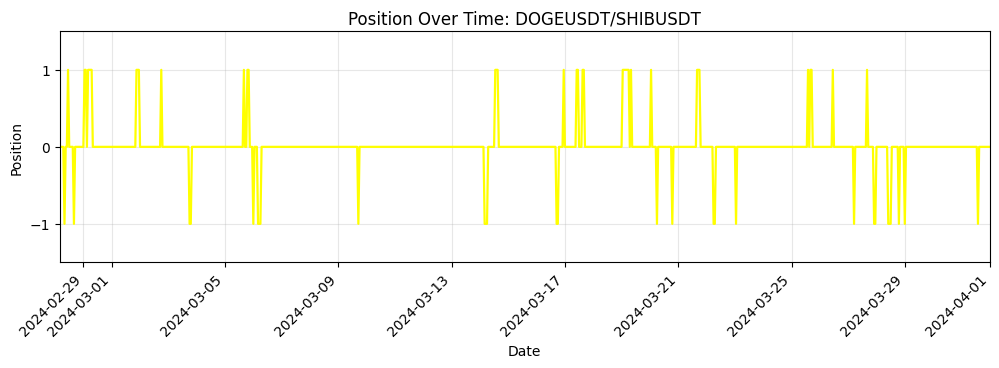

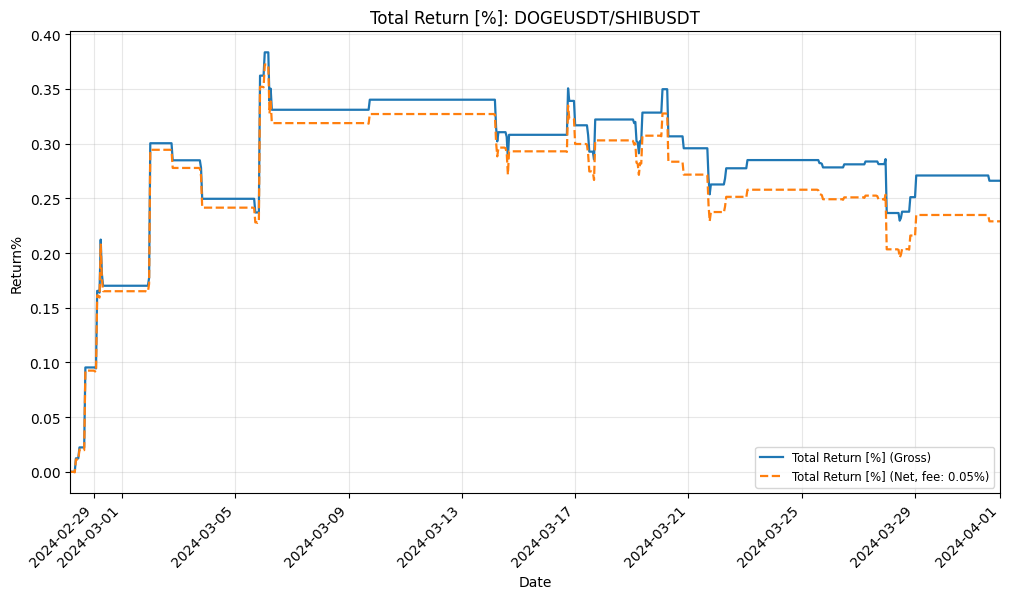

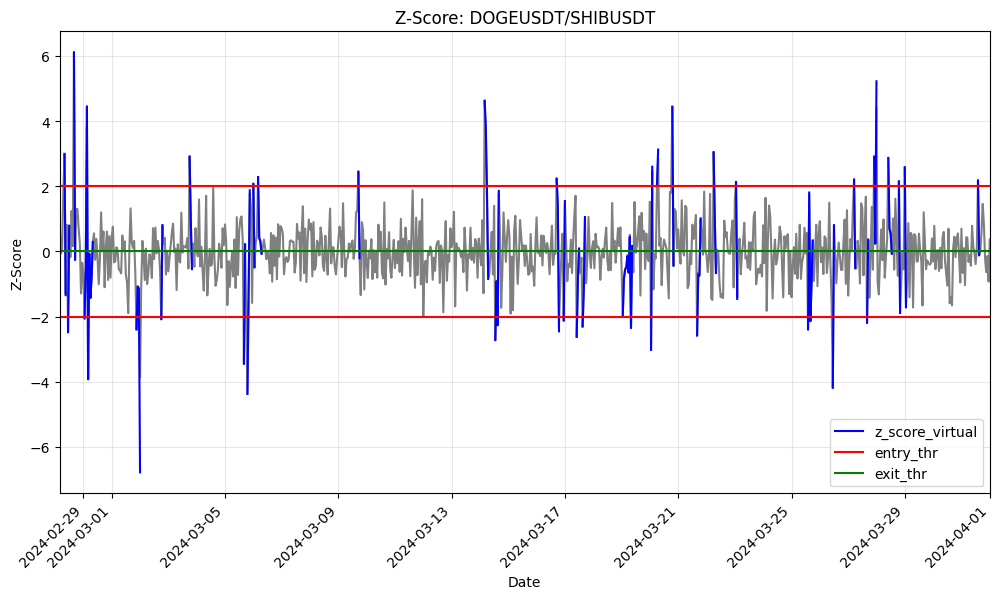

In [10]:
# Visualization
from modules.visualization.plots import plot_pnl, plot_positions, plot_zscore

plot_positions(pair, 'strategy', False, True)
plot_pnl(pair, 'strategy', False, True)
plot_zscore(pair)